# emcee Addendum

A quick exploration of the "proposal scale parameter", a, the number of walkers, and the mean acceptance fraction for the chains.

NB: The examples with just a handful of walkers shouldn't be construed as a suggestion to use such small numbers for actual implementations where you need accurate results. As you will see from the corner plots, the posterior distributions are not well sampled. Additionally, the runs with lower number of walkers appear to require longer "burn-in" times, which I have not made allowances for in this demonstration.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner

In [3]:
nthreads=2

In [4]:
# define our true relation
m_true = 1.7
b_true = 2.7
f_true = 0.3

In [5]:
# generate some data
N = 30
x = np.sort(10*np.random.rand(N))
yerr = 0.2+0.6*np.random.rand(N)

y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)

y += yerr * np.random.randn(N)

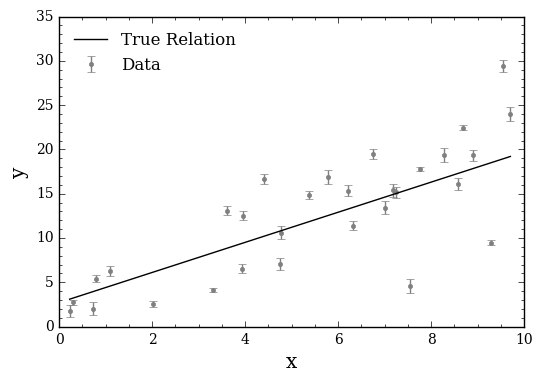

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

In [7]:
def lnlike(theta, x, y, yerr):
    b, m, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [8]:
# let's make some initial guesses for our parameters
# remember this is now theta and b_perp
p2 = [b_true, m_true, f_true]
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll,
                     p2,
                     args=(x, y, yerr))
if not(result['success']):
    print("Max likelihood failed.")
    print(result['message'])

ml_b, ml_m, ml_f = result['x']

In [9]:
def lnprior(theta):
    b, m, lnf = theta
    if lnf >= 0.0:
        return -np.inf
    return 0.0

In [10]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [11]:
# now let's set up the MCMC chains
ndim = 3
nwalkers = [6, 10, 50, 100, 500]
wcolors = ['k', 'b', 'g', 'r', 'c']
steps = 500

dim_name = [r'$b$', r'$m$', r'$\ln f$']

In [12]:
# explore a range of scale parameters
scales = [2, 4, 6, 8]

6 walkers and 2.0 scale.
6 walkers and 4.0 scale.
6 walkers and 6.0 scale.
6 walkers and 8.0 scale.
10 walkers and 2.0 scale.
10 walkers and 4.0 scale.
10 walkers and 6.0 scale.
10 walkers and 8.0 scale.
50 walkers and 2.0 scale.
50 walkers and 4.0 scale.
50 walkers and 6.0 scale.
50 walkers and 8.0 scale.
100 walkers and 2.0 scale.
100 walkers and 4.0 scale.
100 walkers and 6.0 scale.
100 walkers and 8.0 scale.
500 walkers and 2.0 scale.
500 walkers and 4.0 scale.
500 walkers and 6.0 scale.
500 walkers and 8.0 scale.


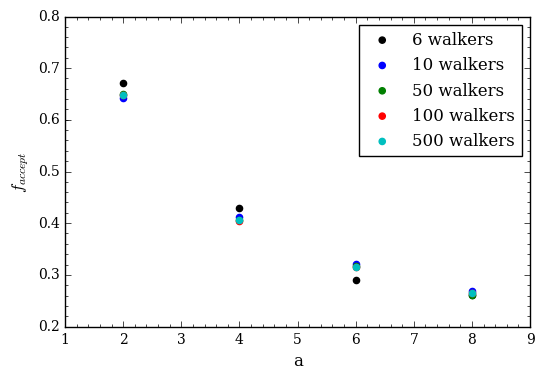

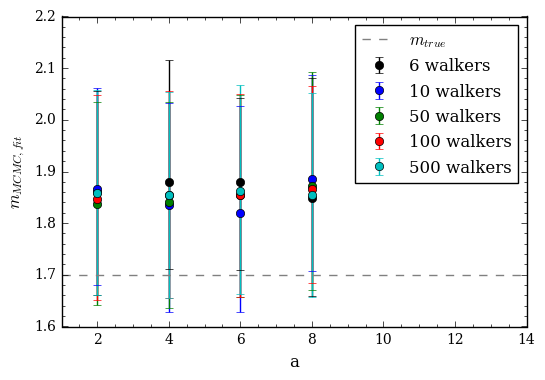

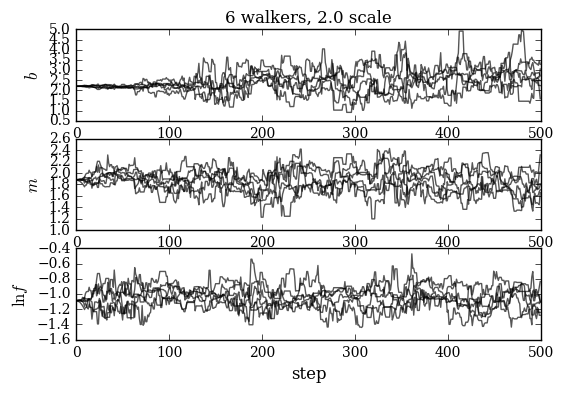

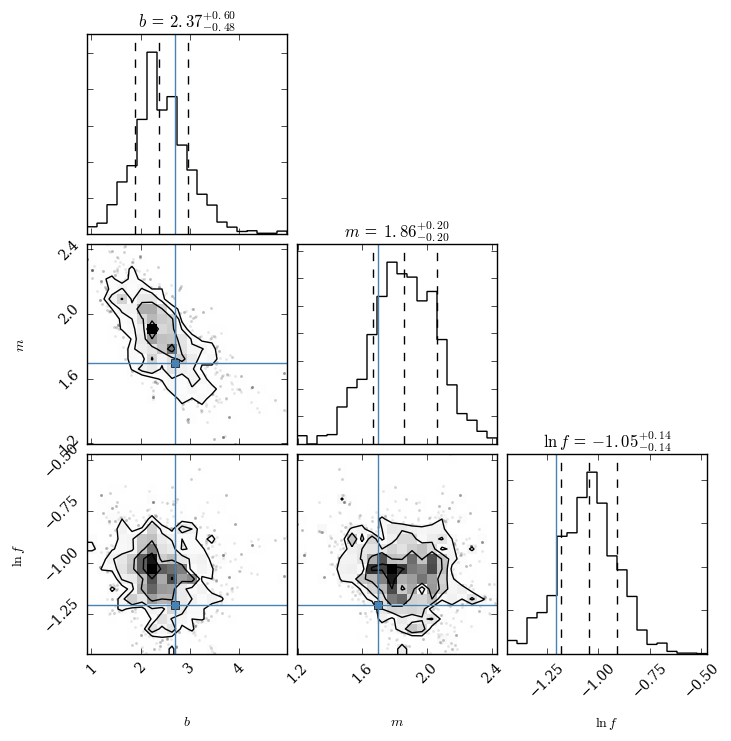

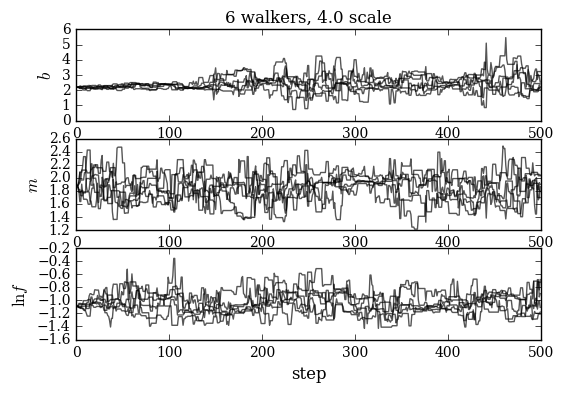

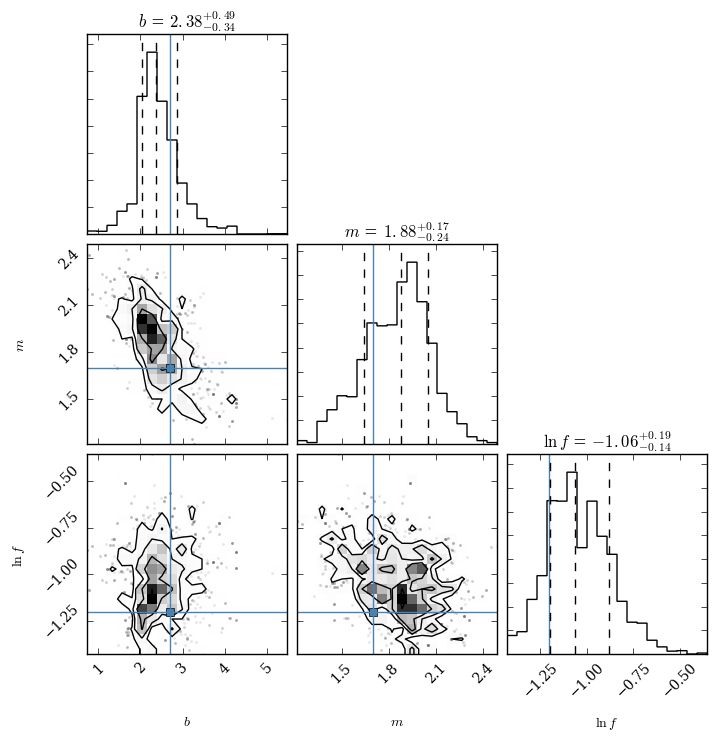

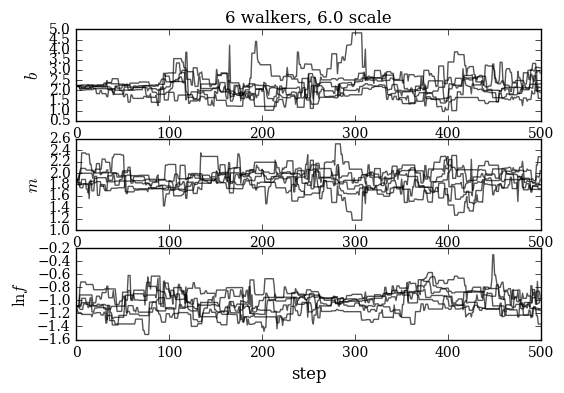

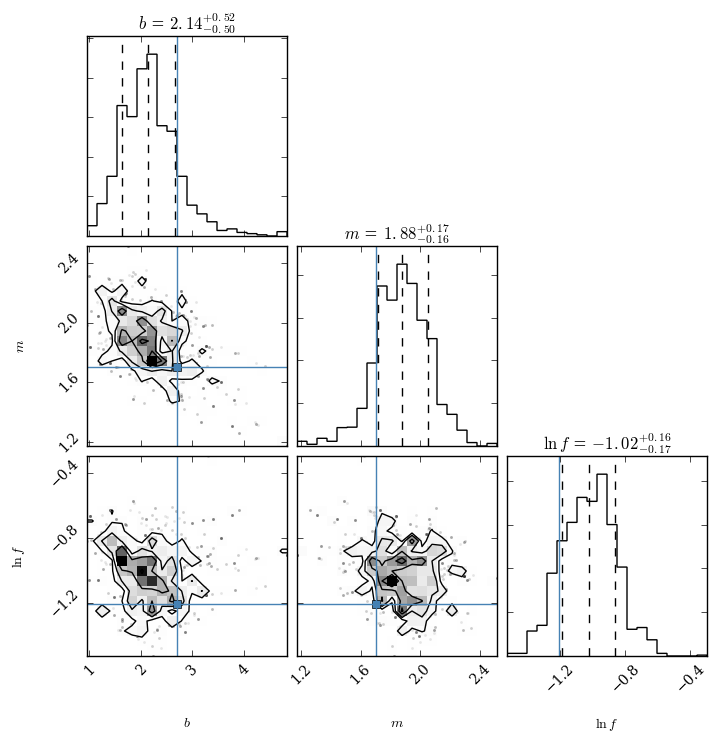

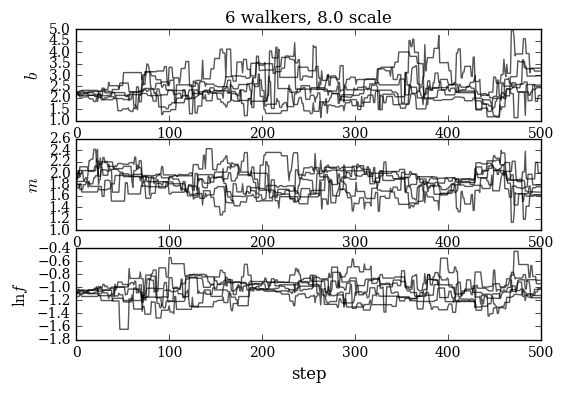

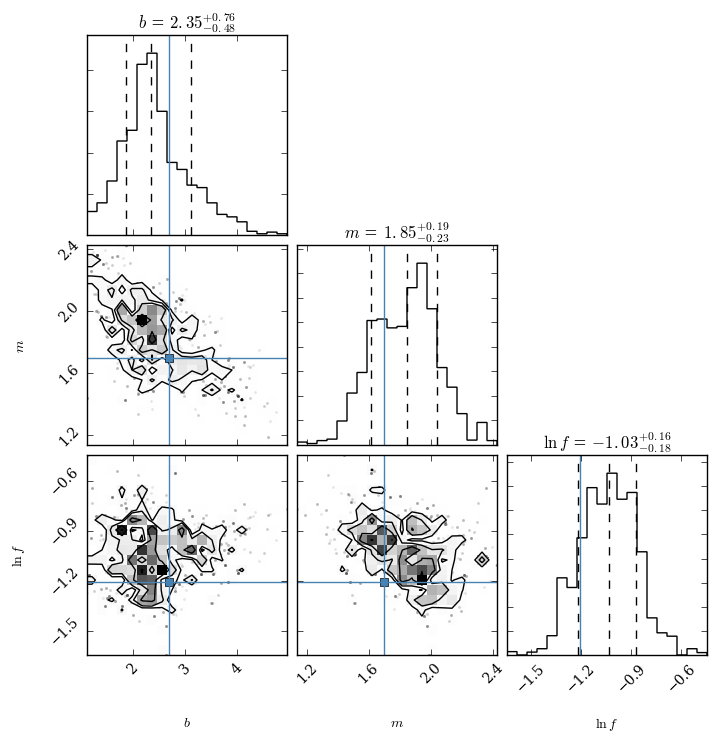

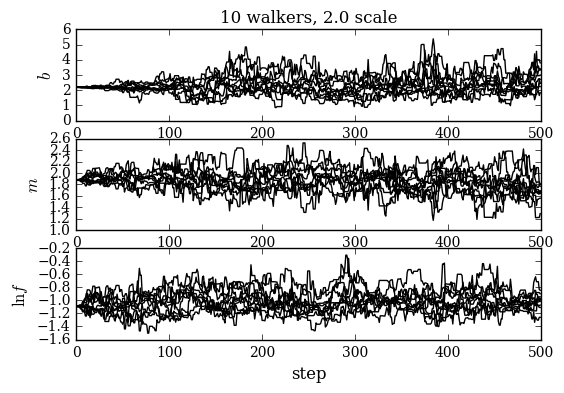

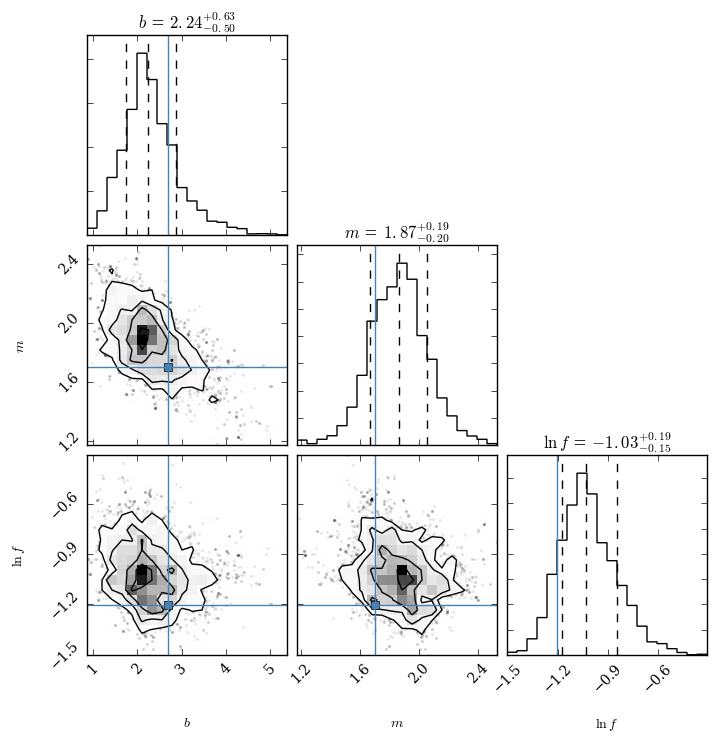

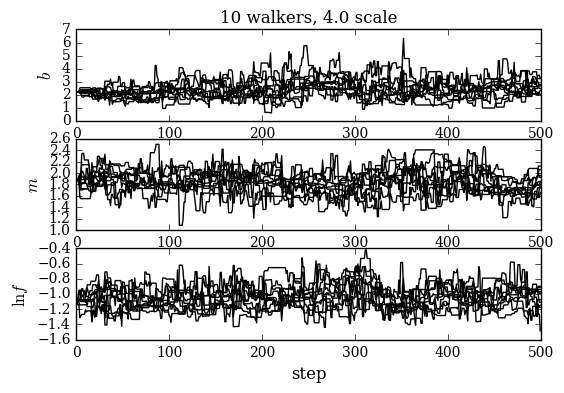

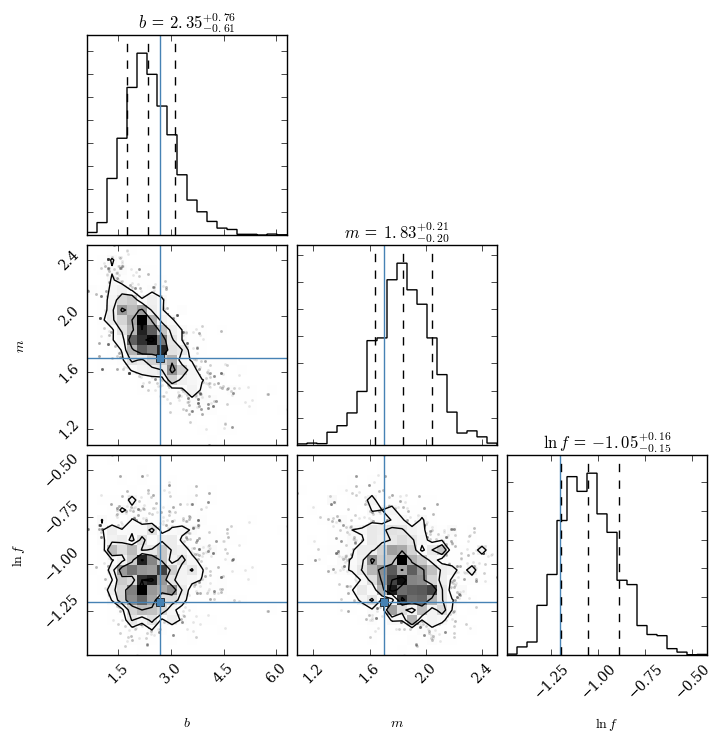

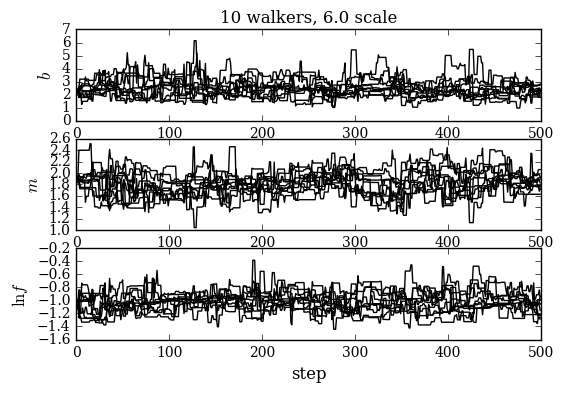

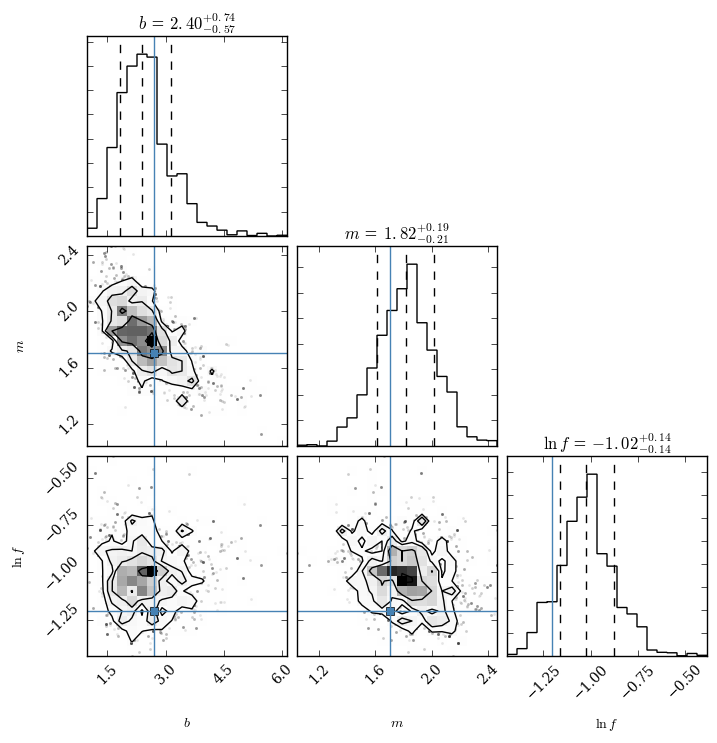

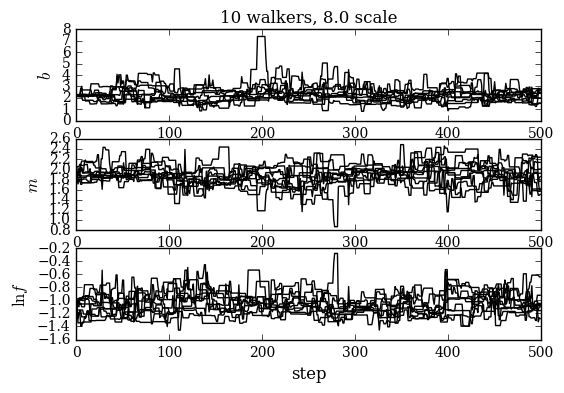

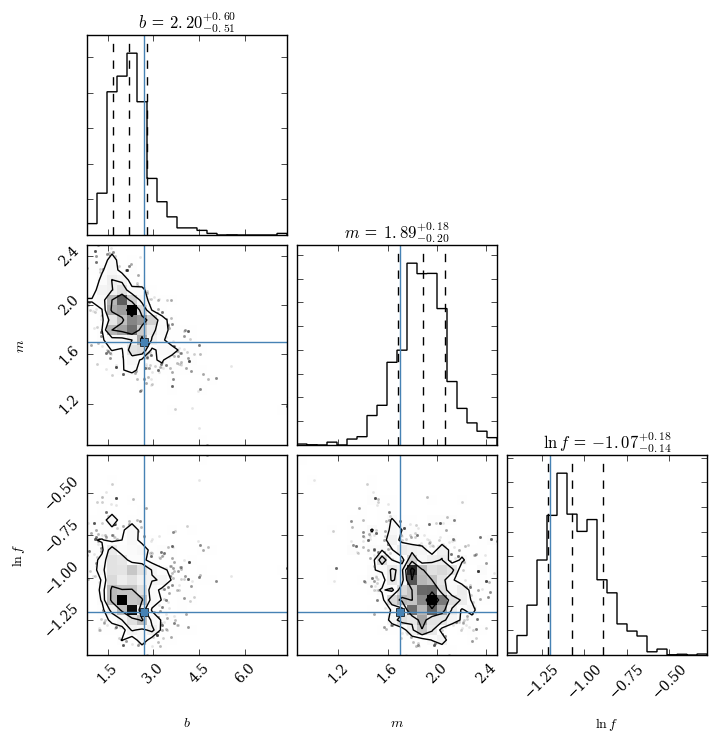

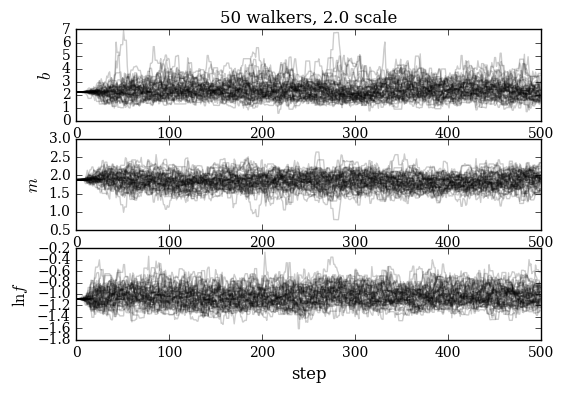

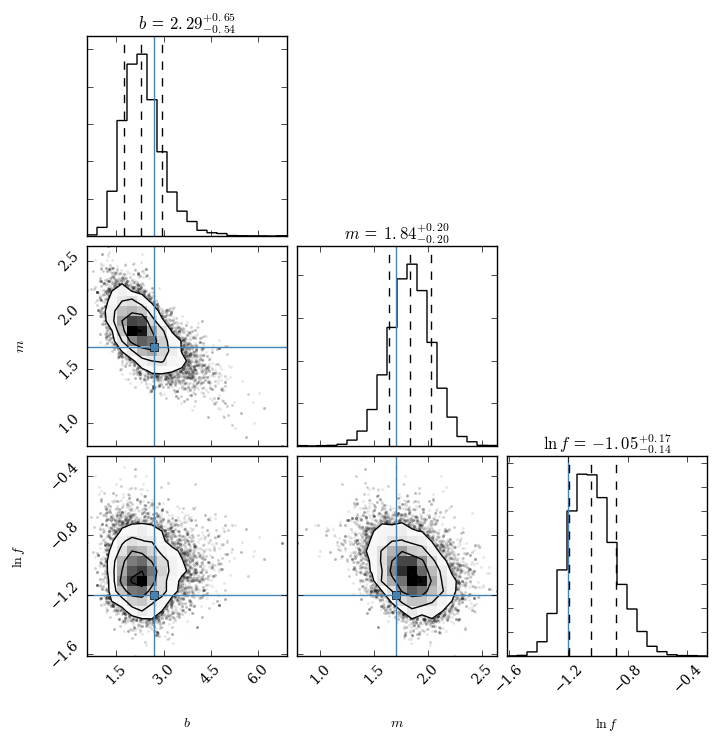

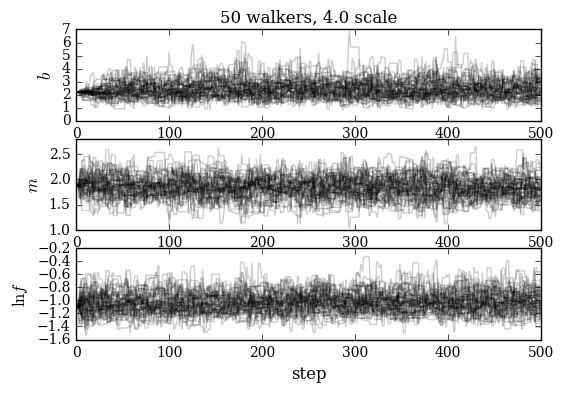

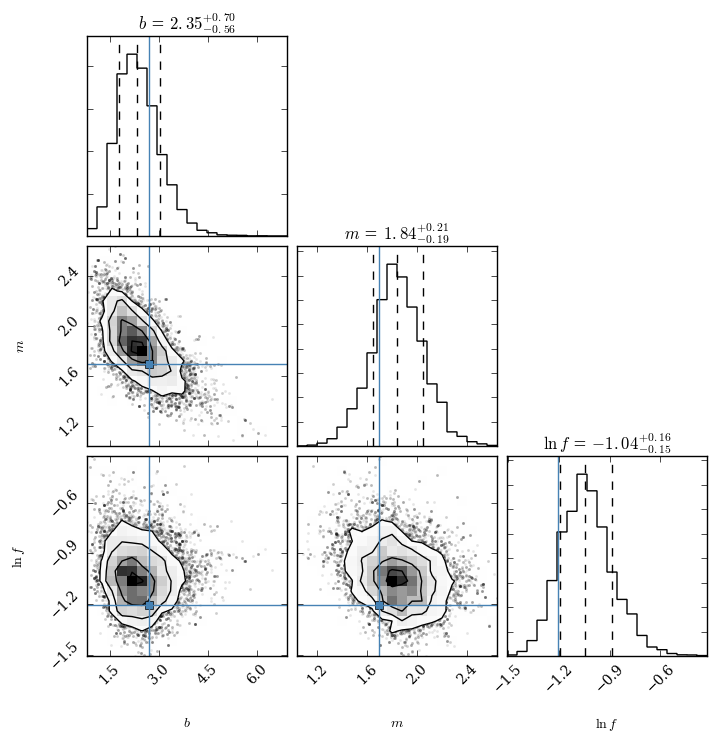

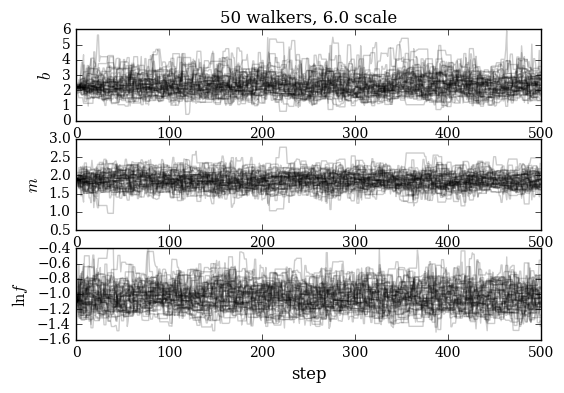

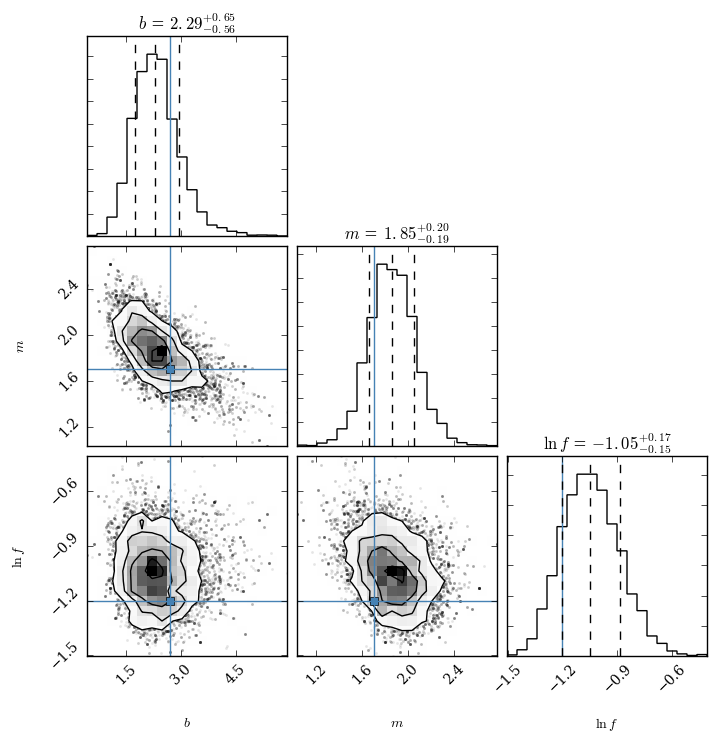

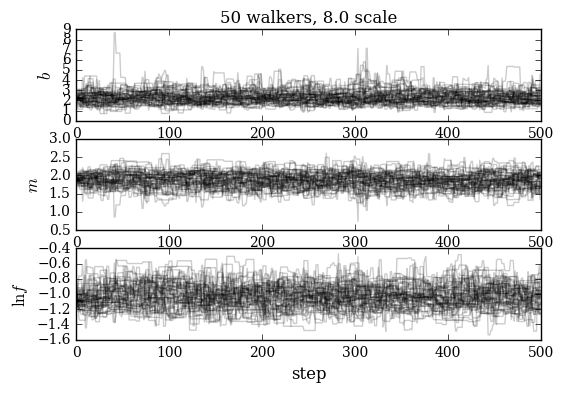

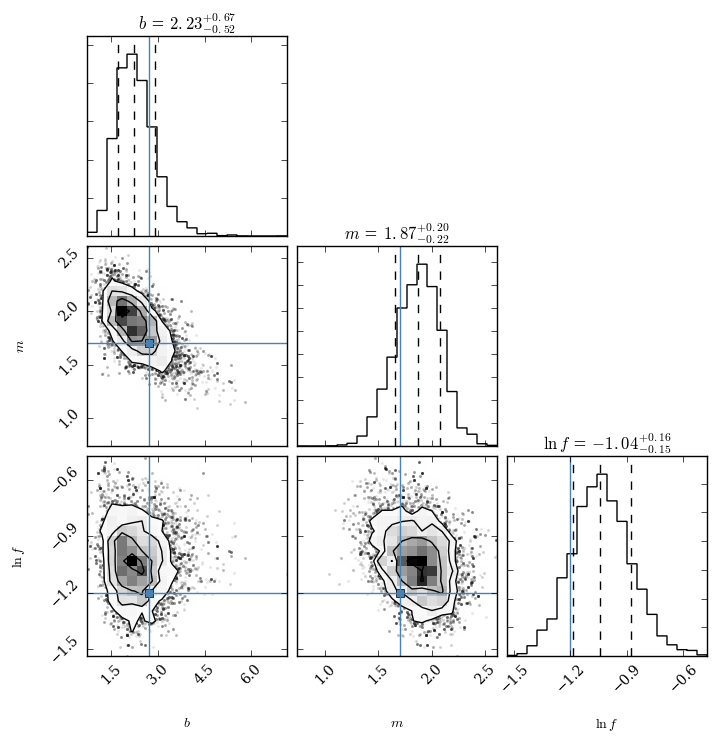

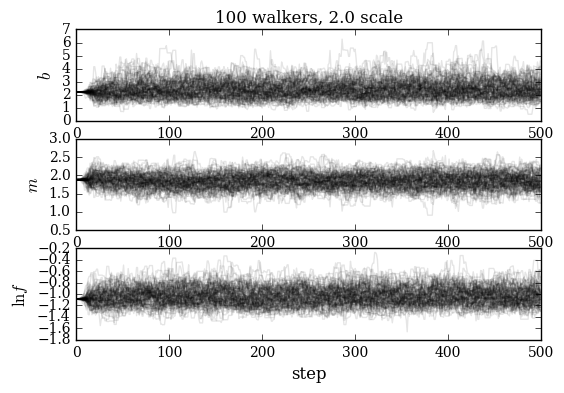

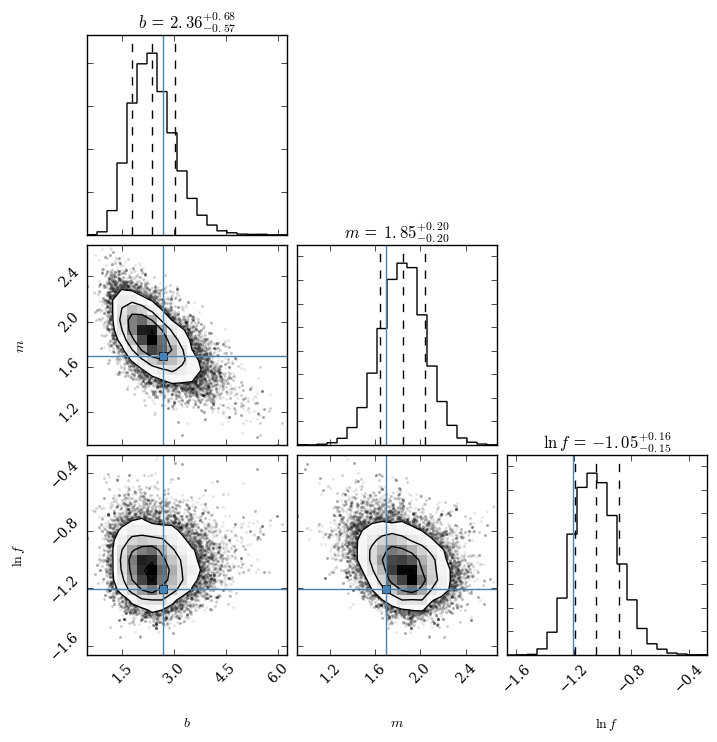

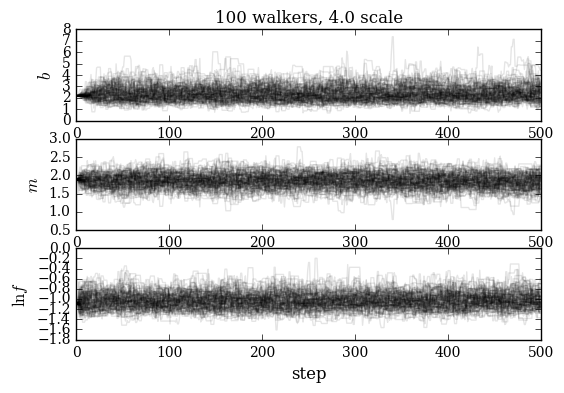

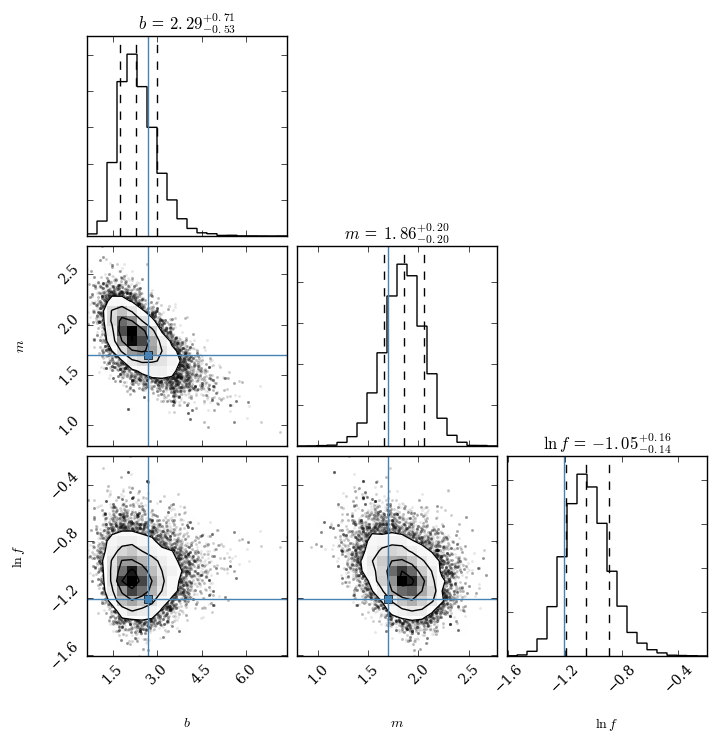

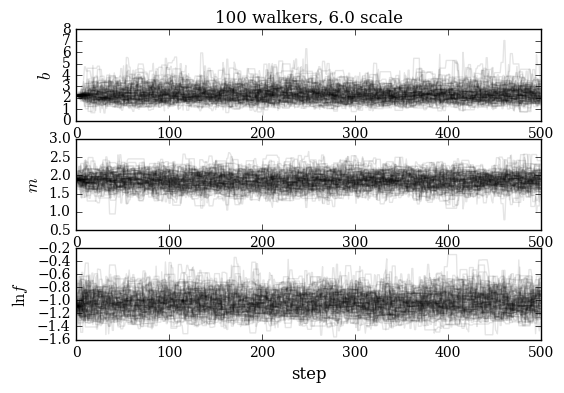

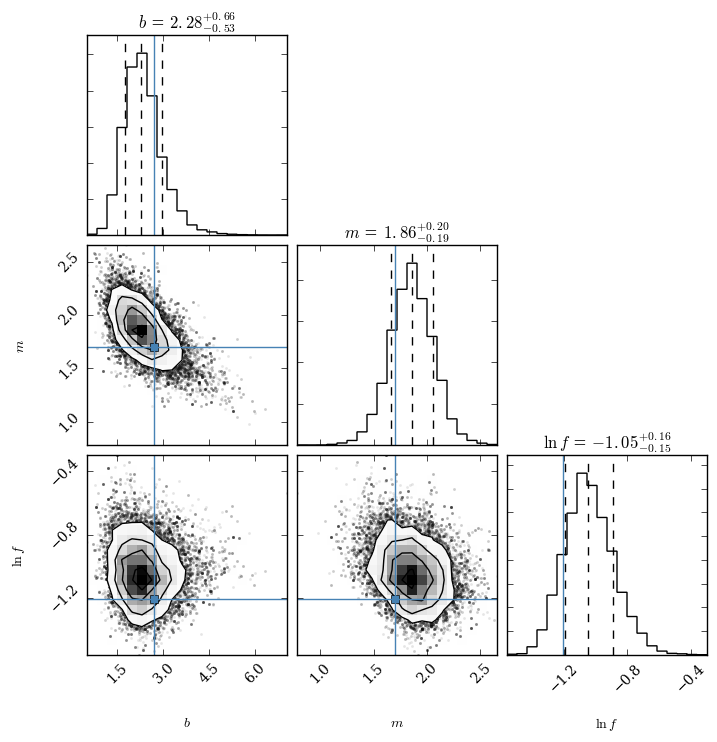

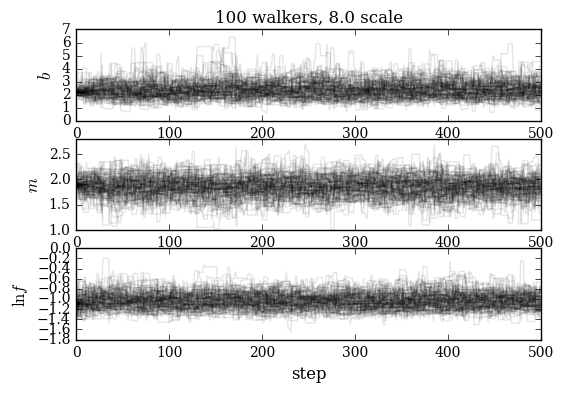

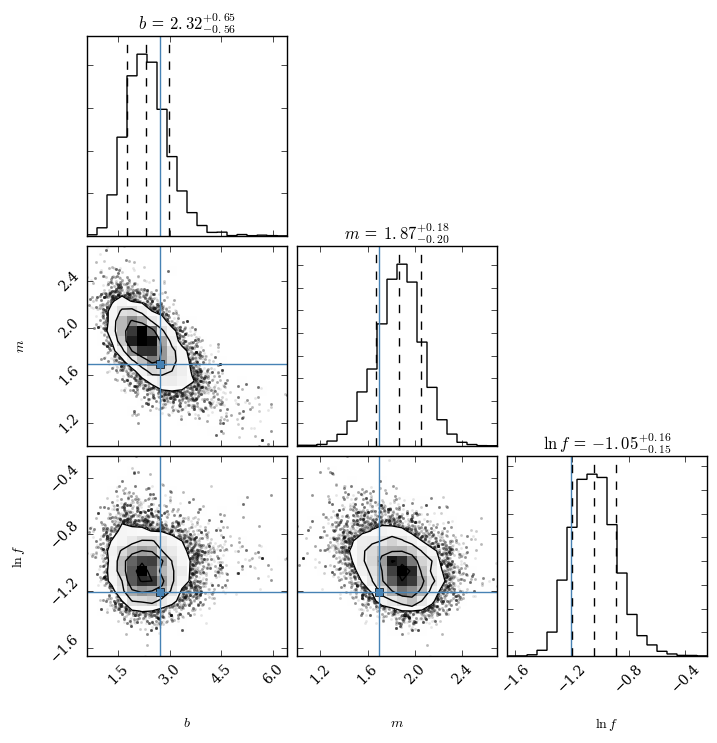

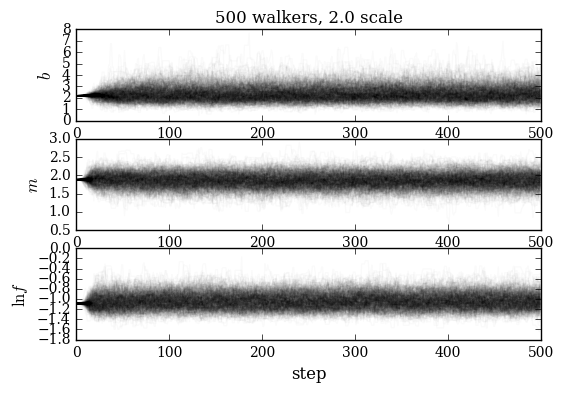

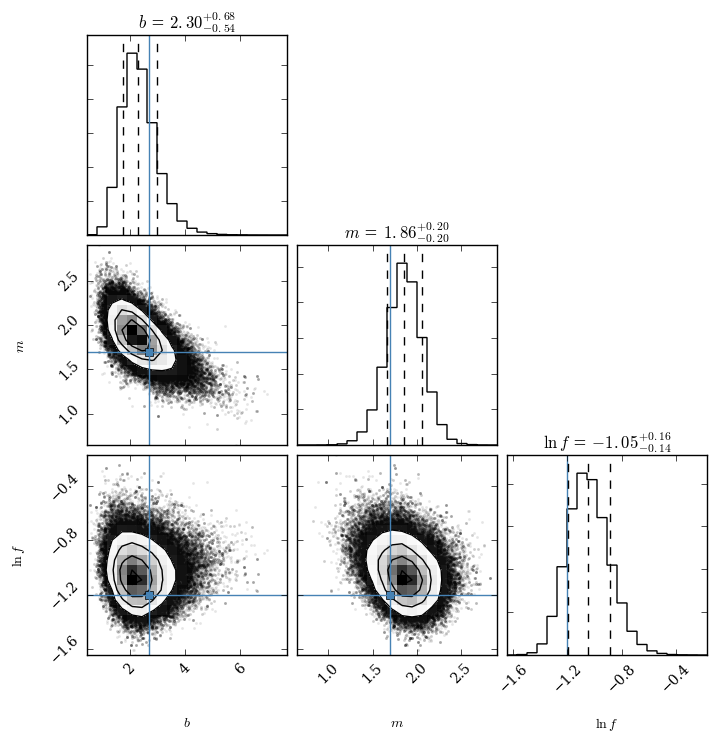

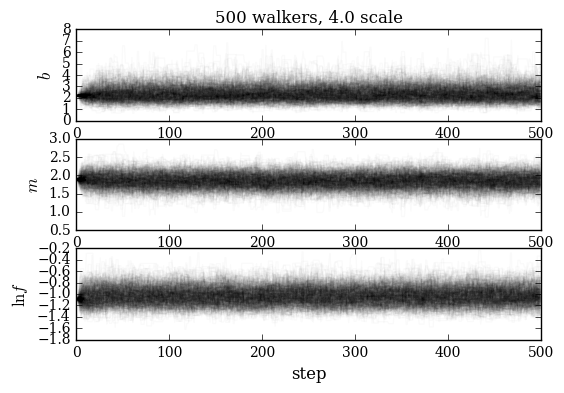

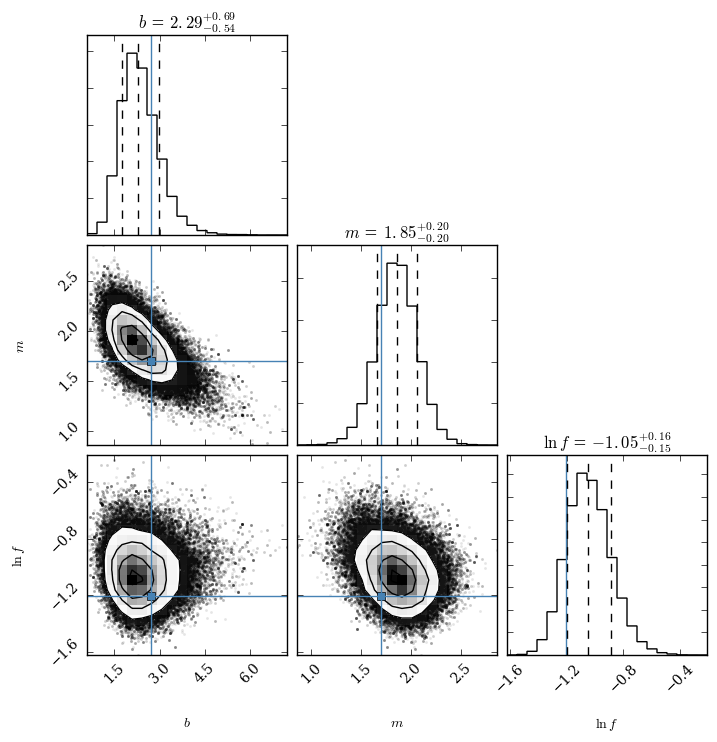

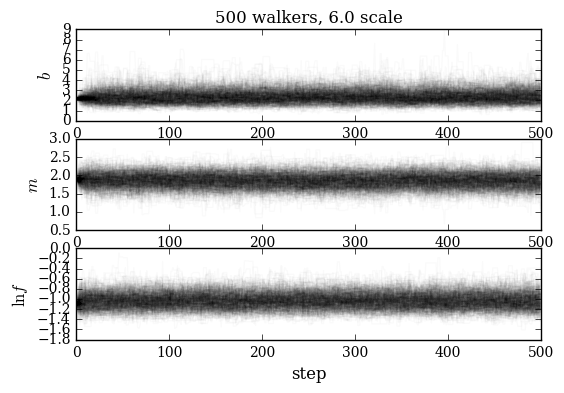

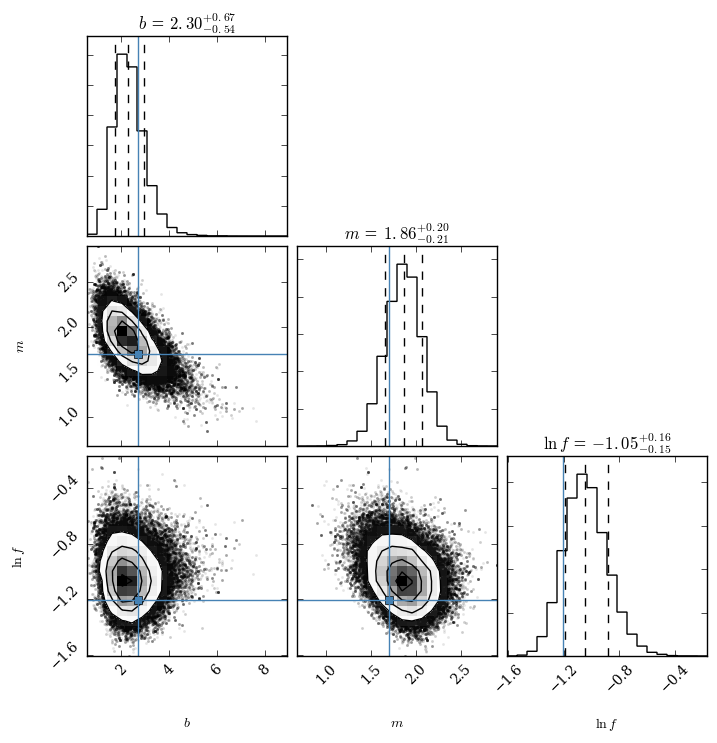

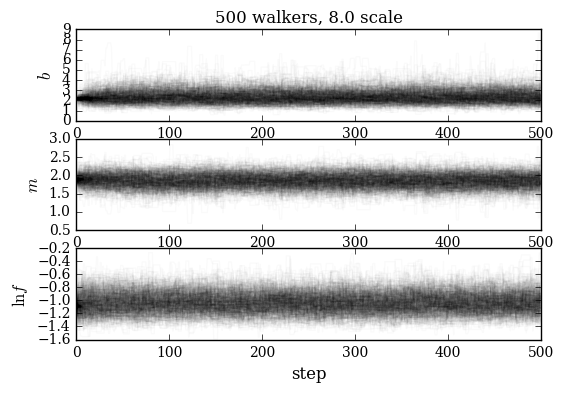

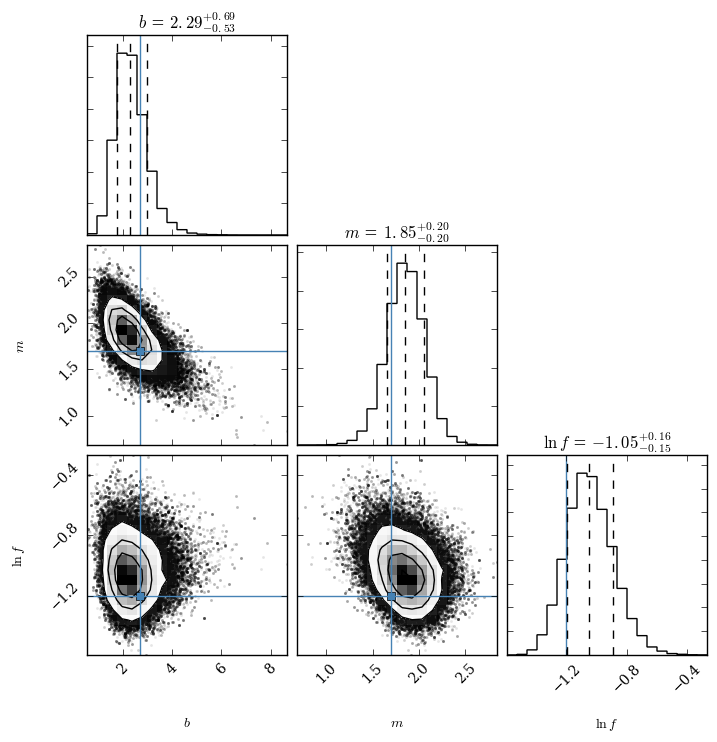

In [13]:
faccfig = plt.figure()
faccax = faccfig.add_subplot(1, 1, 1)
sfig = plt.figure()
sax = sfig.add_subplot(1, 1, 1)
for wco, walkers in enumerate(nwalkers):
    afrac = []
    # initialize the walkers to the vicinity of the parameters derived from
    # ML
    pos = [result["x"] + 1e-3*np.random.randn(ndim) for i in range(walkers)]
    for a in scales:
        print("{0:d} walkers and {1:1.1f} scale.".format(walkers, a))
        # initialze the sampler
        sampler = emcee.EnsembleSampler(walkers,
                                        ndim,
                                        lnprob,
                                        a=a,
                                        args=(x,
                                              y,
                                              yerr),
                                        threads=nthreads)
        sampler.run_mcmc(pos, steps)
        samples = sampler.chain
        fig = plt.figure()
    
        for dim in range(ndim):
            ax = fig.add_subplot(ndim, 1, dim+1)
            if dim==0:
                ax.set_title('{0:d} walkers, {1:1.1f} scale'.format(walkers, a))
            for i in range(walkers):
                ax.plot(np.arange(steps),
                        samples[i, :, dim],
                        ls='-',
                        color='black',
                        alpha=10./walkers)
            ax.set_ylabel(dim_name[dim], fontsize='large')
        ax.set_xlabel('step', fontsize='large')
        
        # visualize the results
        # ignore first 50 steps for burn in
        samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
        corner.corner(samples,
                      labels=[r"$b$", r"$m$", r"$\ln\,f$"],
                      quantiles=[0.16, 0.5, 0.84],
                      truths=[b_true,
                              m_true,
                              np.log(f_true)],
                      show_titles=True)
        
        # get the best-fit slope
        samples[:, 2] = np.exp(samples[:, 2])
        b_mcmc, m_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))
        afrac.append((a, np.mean(sampler.acceptance_fraction), m_mcmc[0], m_mcmc[1], m_mcmc[2]))
        
    afrac = np.array(afrac)

    faccax.scatter(afrac[:,0], afrac[:, 1],
                   marker='o',
                   color=wcolors[wco],
                   label="{0:d} walkers".format(walkers))
    sax.errorbar(afrac[:, 0],
                 afrac[:, 2],
                 yerr=[afrac[:, 3], afrac[:,4]],
                 marker='o',
                 ls='',
                 color=wcolors[wco],
                 label="{0:d} walkers".format(walkers))
faccax.set_xlabel(r'a', fontsize='large')
faccax.set_ylabel(r'$f_{accept}$', fontsize='large')
faccax.minorticks_on()
faccax.legend(loc='best', frameon=True)
sax.axhline(m_true, ls='--', color='gray', label=r'$m_{true}$')
sax.set_xlabel(r'a', fontsize='large')
sax.set_ylabel(r'$m_{MCMC,fit}$', fontsize='large')
sax.set_xlim([scales[0]-1, scales[-1] + 6])
ylim = sax.get_ylim()
sax.set_ylim([np.min([m_true-0.1, ylim[0]]), np.max([m_true+0.1, ylim[1]])])
sax.minorticks_on()
sax.legend(loc='best', frameon=True)